# ARIMA model 

- Temperature Dataset

### Step 1: Importing neccesary libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

### Step 2: Load the dataset

In [34]:
# Load the dataset
data = pd.read_csv('../Dataset/perrin-freres-monthly-champagne-.csv')
data.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [35]:
data.isnull().sum()

Month                                                     1
Perrin Freres monthly champagne sales millions ?64-?72    2
dtype: int64

In [36]:
data.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [37]:
data.columns=["Months","Sales"]
data.head()

,Months,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [38]:
data.drop(105,axis=0,inplace=True)

In [39]:
data.tail()

,Months,Sales
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
106,Perrin Freres monthly champagne sales millions...,NaN


### Step 3: Data Preprocessing

<Axes: >

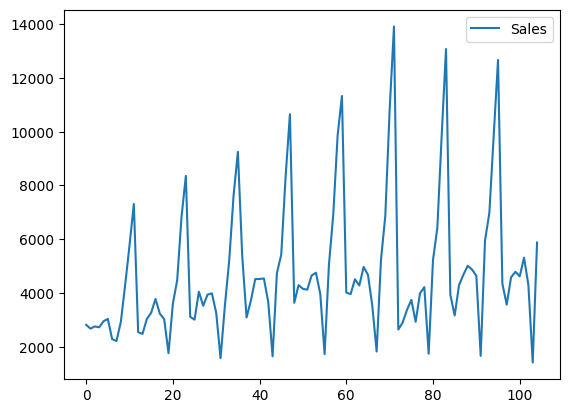

In [43]:
data.plot()

In [44]:
# Convert the 'Datetime' column to a datetime object
data['Months'] = pd.to_datetime(data['Months'])
data.head()
# Set the 'Datetime' column as the DataFrame index
# data.set_index('Datetime', inplace=True)


ValueError: time data "Perrin Freres monthly champagne sales millions ?64-?72" doesn't match format "%Y-%m", at position 105. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [45]:
data.set_index('months',inplace=True)
data.head()

KeyError: "None of ['months'] are in the columns"

### Step 4: Data Visualization

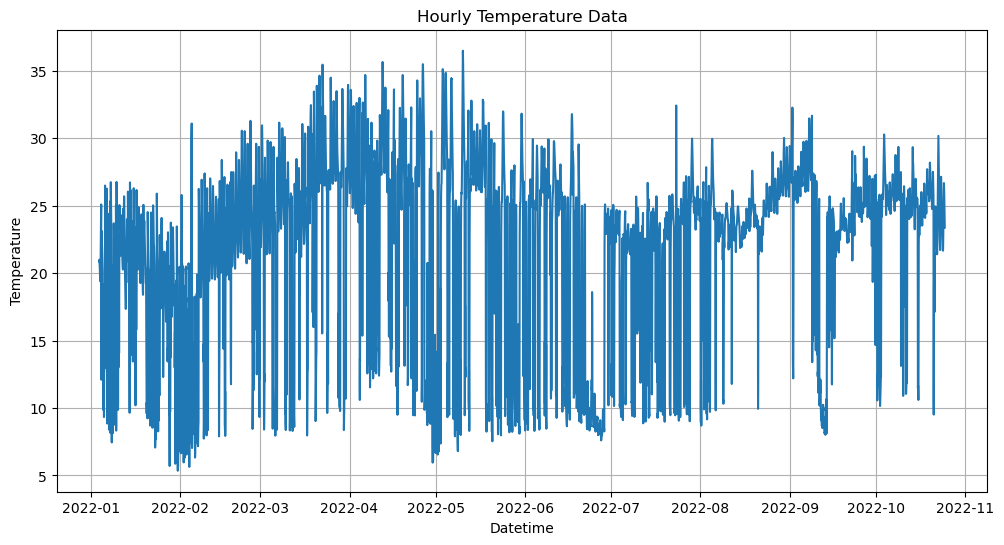

In [4]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data['Hourly_Temp'])
plt.title('Hourly Temperature Data')
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.grid(True)
plt.show()


### Step 5: Check Stationarity

In [5]:
# Define a function to check stationarity and perform differencing
def test_stationarity(timeseries):
    # Dickey-Fuller test
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value

    return dfoutput

# Check stationarity
result = test_stationarity(data['Hourly_Temp'])
print("Augmented Dickey-Fuller Test:")
print(result)

Augmented Dickey-Fuller Test:
Test Statistic                -9.396891e+00
p-value                        6.338903e-16
#Lags Used                     2.500000e+01
Number of Observations Used    7.030000e+03
Critical Value (1%)           -3.431281e+00
Critical Value (5%)           -2.861951e+00
Critical Value (10%)          -2.566989e+00
dtype: float64


### Step 6: Perform Differencing

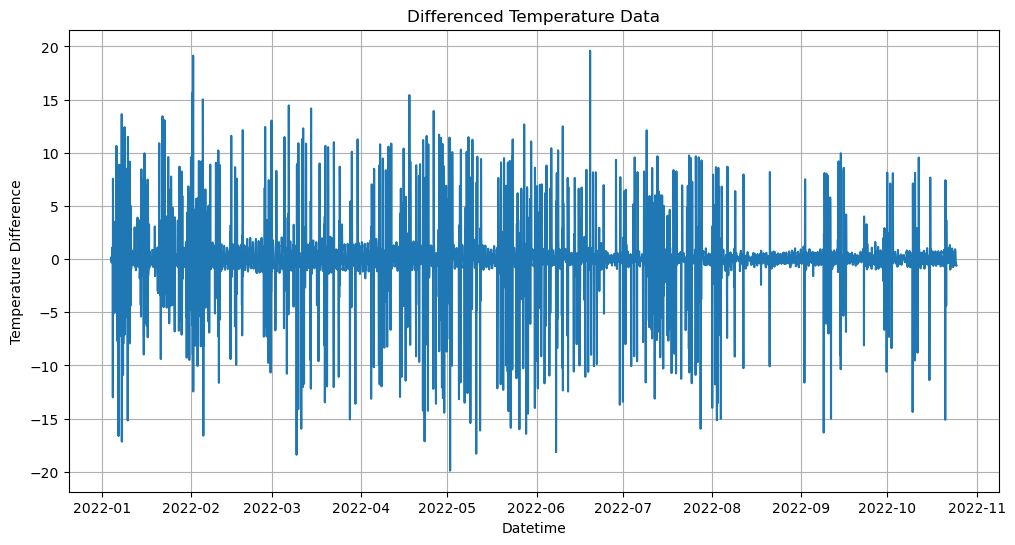

In [6]:
# Differencing to make the series stationary
data['Temp_Diff'] = data['Hourly_Temp'] - data['Hourly_Temp'].shift(1)
data.dropna(inplace=True)

# Plot differenced data
plt.figure(figsize=(12, 6))
plt.plot(data['Temp_Diff'])
plt.title('Differenced Temperature Data')
plt.xlabel('Datetime')
plt.ylabel('Temperature Difference')
plt.grid(True)
plt.show()

### Step 7: Check Stationarity of Differenced Data

In [7]:
# Check stationarity of differenced data
result = test_stationarity(data['Temp_Diff'])
print("Augmented Dickey-Fuller Test on Differenced Data:")
print(result)

Augmented Dickey-Fuller Test on Differenced Data:
Test Statistic                  -20.546080
p-value                           0.000000
#Lags Used                       35.000000
Number of Observations Used    7019.000000
Critical Value (1%)              -3.431282
Critical Value (5%)              -2.861952
Critical Value (10%)             -2.566989
dtype: float64


### Step 8: Fit SARIMA Model

In [8]:
# Fit SARIMA model
model = SARIMAX(data['Hourly_Temp'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
results = model.fit(disp=False)

### Step 9: Forecast Future Values

In [9]:
# Forecast future values
forecast_steps = 24  # Adjust this as needed
forecast = results.get_forecast(steps=forecast_steps)


### Step 10: Create Date Range for Forecasting

In [10]:
# Create a date range for forecasting
date_range = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='H')

### Step 11: Get Forecasted Values and Confidence Intervals

In [11]:
# Get forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

### Step 12: Create a Forecast DataFrame

In [12]:
# Create a forecast DataFrame
forecast_df = pd.DataFrame({'Forecast': forecast_values, 'Lower_CI': forecast_conf_int.iloc[:, 0], 'Upper_CI': forecast_conf_int.iloc[:, 1]}, index=date_range[1:])

### Step 13: Plot the Original Data and the Forecast

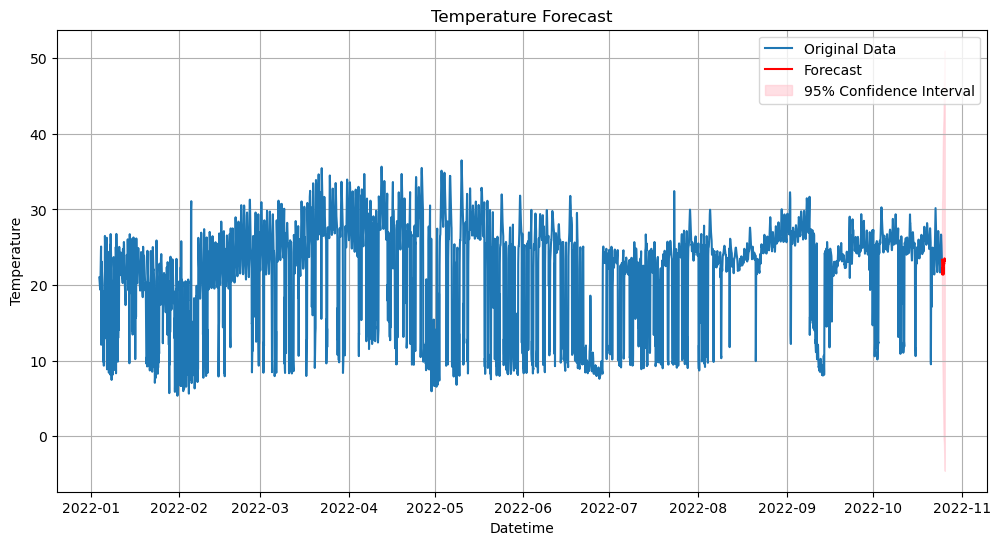

In [13]:
# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(data['Hourly_Temp'], label='Original Data')
plt.plot(forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, forecast_df['Lower_CI'], forecast_df['Upper_CI'], color='pink', alpha=0.5, label='95% Confidence Interval')
plt.title('Temperature Forecast')
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()